# Libraries

In [1]:
import h5py
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics  import r2_score
from glob             import glob

import matplotlib.pyplot as plt
import scipy.signal      as signal
import torch.nn          as nn
import numpy  			 as np
import pandas 		     as pd


# ECG Definitions

ECG metadata

In [2]:
samplingFrequency = 400

ECG file headers

In [3]:
ecgHeaders = [
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ECG plot definitions

In [4]:
ecgPlotHeaders = [
	"LI", "aVR", "V1", "V4",
	"LII", "aVL", "V2", "V5",
	"LIII", "aVF", "V3", "V6"
]

ecgPlotColors = {
	"LI":   "seagreen",
	"aVR":  "black",
	"V1":   "gold",
	"V4":   "orangered",
	"LII":  "cornflowerblue",
	"aVL":  "seagreen",
	"V2":   "gold",
	"V5":   "crimson",
	"LIII": "cornflowerblue",
	"aVF":  "cornflowerblue",
	"V3":   "orangered",
	"V6":   "crimson"
}

# The Dataset: CODE-15

Metadata

In [5]:
dataFolder = "../../../data/CODE15/hdf5/"

In [6]:
ecgHeaders += ["Z"]

In [7]:
ecgFeatures = [
	"LII", 
	"Z"  , # Z = -0,5 * V2 
	"V6" , 
]

ecgFeaturesIndexes = [ecgHeaders.index(derivation) for derivation in ecgFeatures]
ecgFeaturesIndexes

[1, 12, 11]

In [8]:
ecgTarget = [
	"LI", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V3",
	"V4",
	"V5",
]

ecgTargetIndexes = [ecgHeaders.index(derivation) for derivation in ecgTarget]
ecgTargetIndexes

[0, 2, 3, 4, 5, 6, 8, 9, 10]

Dataset class

In [9]:
class Code15Dataset(Dataset):
	def __init__(self, hdf5Files, features, target, transform):
		
		super().__init__()
		
		self.hdf5Files = hdf5Files
		self.indexMap  = []
		self.features  = features
		self.target    = target
		self.transform = transform


		for fileIndex, path in enumerate(self.hdf5Files):
			
			with h5py.File(path, "r") as f:
				samplesCount = f['exam_id'].shape[0]
				
				self.indexMap.extend([(fileIndex, i) for i in range(samplesCount)])

	def __len__(self):
		return len(self.indexMap)

	def __getitem__(self, idx):

		fileIndex, examIdx = self.indexMap[idx]
		hdf5File           = self.hdf5Files[fileIndex]

		with h5py.File(hdf5File, "r") as file:
			tracing = np.array(file['tracings'][examIdx])

		tracing = self.transform(tracing)

		X = tracing[:, self.features]
		X = torch.tensor(X, dtype = torch.float32)

		Y = tracing[:, self.target]
		Y = torch.tensor(Y, dtype = torch.float32)

		return X, Y


Transform Function

- highpass butterworth filter with $ f_c = 1$ Hz
- Truncation in the tails of $ N = 600  $ samples
- Gain of 5
- Normalization with z-score
- Create Z lead

In [10]:
def transform(ecg):
	b, a = signal.butter(
		N     = 1, 
		Wn    = 1, 
		btype = 'high', 
		fs    = samplingFrequency
	)
	
	ecgFiltred  = signal.filtfilt(b, a, ecg, axis = 0)
	ecgWithGain = 5 * ecgFiltred
	ecgClean    = ecgWithGain[600: -600, :]

	# Build Z feature: -0,5 * V2 
	z = -0.5 * ecgClean[:, ecgHeaders.index("V2")]
	z = z.reshape(-1 , 1)

	ecgClean = np.concatenate((ecgClean, z), axis = 1)

	ecgMean = np.mean(ecgClean, axis = 0, keepdims = True)
	ecgStd  = np.std(ecgClean,  axis = 0, keepdims = True) + 1e-8

	ecgNormalized = (ecgClean - ecgMean) / ecgStd

	return ecgNormalized


Holdout dataset

In [11]:
dataset = Code15Dataset(
	hdf5Files = glob(f"{dataFolder}/*.hdf5")[:-9],
	features  = ecgFeaturesIndexes,
	target    = ecgTargetIndexes,	
	transform = transform
)

In [12]:
len(dataset)

20001

In [13]:
generator = torch.Generator().manual_seed(14)

In [14]:
trainRatio = 0.80

trainSize = int(trainRatio * len(dataset))
testSize  = len(dataset) - trainSize

print("Train dataset Len =", trainSize)
print("Train dataset Len =", testSize)

Train dataset Len = 16000
Train dataset Len = 4001


In [15]:
trainDataset, testDataset = random_split(
	dataset = dataset,
	lengths = [trainSize, testSize]
)

Dataloaders

In [16]:
trainDataloader = DataLoader(
	dataset     = trainDataset,
	batch_size  = 32,
	shuffle     = True,
	num_workers = 4

)

testDataloader = DataLoader(
	dataset     = testDataset,
	batch_size  = 32,
	shuffle     = False,
	num_workers = 4

)

# Model definition

In [17]:
class ECGReconstructor(nn.Module):
	def __init__(self):
		super().__init__()

		self.linear = nn.Linear(
			in_features  = 3,
			out_features = 9
		)

	def forward(self, X):
		return self.linear(X)

# Training

Metadata

In [18]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = ECGReconstructor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.MSELoss()
epochs    = 10

print(device)

cuda


Run

In [19]:
trainingLoss = []

In [20]:
model.train()

for epoch in range(epochs):
	totalLoss = 0

	for X, Y in trainDataloader:
		X, Y = X.to(device), Y.to(device)

		prediction = model(X)
		loss       = criterion(prediction, Y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		totalLoss += loss.item()

	trainingLoss.append(totalLoss / len(trainDataloader))

	print(f"Epoch {epoch + 1}: loss = {trainingLoss[-1]:.4f}")

Epoch 1: loss = 0.7999
Epoch 2: loss = 0.4652
Epoch 3: loss = 0.4007
Epoch 4: loss = 0.3797
Epoch 5: loss = 0.3713
Epoch 6: loss = 0.3682
Epoch 7: loss = 0.3672
Epoch 8: loss = 0.3669
Epoch 9: loss = 0.3669
Epoch 10: loss = 0.3669


Loss along the epochs

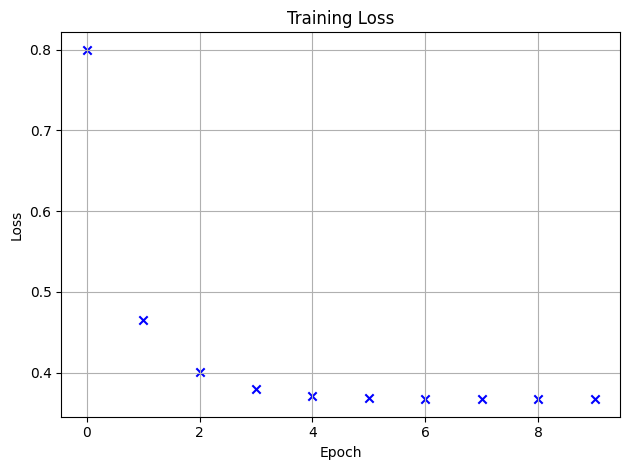

In [21]:
plt.scatter(range(epochs), trainingLoss, c = "blue", marker = "x")

plt.title("Training Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.grid()
plt.tight_layout()
plt.show()

# Test

In [22]:
model.eval()

testLoss = 0
testR2   = 0

totalSamples = 0

with torch.no_grad():
	for X, Y in testDataloader:
		X, Y       =  X.to(device), Y.to(device)
		prediction =  model(X)
		loss       =  criterion(prediction, Y)
		testLoss   += loss.item()

		YFlat 		   = Y.cpu().numpy().reshape(-1, Y.shape[-1])
		predictionFlat = prediction.cpu().numpy().reshape(-1, prediction.shape[-1])

		testR2 += r2_score(YFlat, predictionFlat) * YFlat.shape[0]

		totalSamples += YFlat.shape[0]

testR2 /= totalSamples

print(f"Test Loss: {testLoss:.4f}")
print(f"Test R^2:  {testR2:.4f}")


Test Loss: 46.3243
Test R^2:  0.6304


# Ploting

Ploting functions

In [23]:
def plotECG(ecg, headers, colors): 
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		axes[idx].plot(ecg[header], color = colors[header])
		axes[idx].set_title(f"{header}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

In [24]:
def comparativeFullEcgPlot(ecgOring, ecgRec, headers):
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("Comparison: ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		corr = np.round(ecgOring[header].corr(ecgRec[header]), 3)
		r2   = np.round(r2_score(ecgOring[header], ecgRec[header]), 3)

		axes[idx].plot(
			ecgOring[header], 
			color = "blue", 
			alpha = 0.75
		)
		axes[idx].plot(
			ecgRec[header], 
			color = "red", 
			alpha = 0.75
		)

		axes[idx].set_title(f"{header} CORR = {corr} r2 = {r2}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

Extract a sample ECG from dataset

In [25]:
sampleECGFeaturesTensor, sampleECGTargetTensor = dataset[32]

sampleECGFeatures = pd.DataFrame(
    columns = ecgFeatures,
    data    = sampleECGFeaturesTensor
)

sampleECGTarget = pd.DataFrame(
    columns = ecgTarget,
    data    = sampleECGTargetTensor
)

sampleECG = pd.concat(
    [sampleECGFeatures, sampleECGTarget],
    axis = 'columns'
)

sampleECG["V2"] = sampleECG["Z"] / -0.5

sampleECG.head()


,LII,Z,V6,LI,LIII,aVR,aVL,aVF,V1,V3,V4,V5,V2
0,-0.301953,0.061621,0.032942,-0.298292,0.089561,0.306154,-0.229197,-0.162364,0.499286,-0.077974,-0.116472,-1.662887,-0.123242
1,-0.336523,0.060087,0.042673,-0.391689,0.194455,0.396870,-0.333652,-0.153561,0.499421,-0.075353,-0.116203,-1.634202,-0.120174
2,-0.379945,0.063119,0.018341,-0.460769,0.249162,0.450773,-0.421214,-0.172363,0.442731,-0.087725,-0.122040,-1.615626,-0.126237
3,-0.412026,0.060091,0.002749,-0.506925,0.281781,0.481854,-0.485428,-0.158735,0.403982,-0.098776,-0.113954,-1.589664,-0.120182
4,-0.448528,0.060715,0.045672,-0.523488,0.261466,0.530101,-0.482964,-0.171819,0.407905,-0.093453,-0.112289,-1.557968,-0.121431


In [26]:
with torch.no_grad():
    sampleECGPredicted = model(sampleECGFeaturesTensor.to(device)).cpu().numpy()

sampleECGPredicted = pd.DataFrame(
	columns = ecgTarget,
	data    = sampleECGPredicted
)

sampleECGReconstructed = pd.concat(
    [sampleECGFeatures, sampleECGPredicted],
	axis = 'columns'
)

sampleECGReconstructed["V2"] = sampleECGReconstructed["Z"] / -0.5

sampleECGReconstructed.head()

,LII,Z,V6,LI,LIII,aVR,aVL,aVF,V1,V3,V4,V5,V2
0,-0.301953,0.061621,0.032942,-0.043530,-0.262133,0.180722,0.108964,-0.341151,0.004465,-0.105829,-0.089308,-0.049581,-0.123242
1,-0.336523,0.060087,0.042673,-0.044667,-0.296270,0.199558,0.126603,-0.382110,0.007190,-0.110562,-0.092969,-0.049581,-0.120174
2,-0.379945,0.063119,0.018341,-0.069051,-0.317839,0.235553,0.122145,-0.422242,0.023348,-0.124975,-0.118371,-0.077121,-0.126237
3,-0.412026,0.060091,0.002749,-0.085503,-0.335580,0.261443,0.121112,-0.452668,0.037181,-0.131257,-0.133765,-0.094917,-0.120182
4,-0.448528,0.060715,0.045672,-0.066290,-0.390096,0.270178,0.162797,-0.505972,0.025006,-0.133839,-0.121770,-0.071338,-0.121431


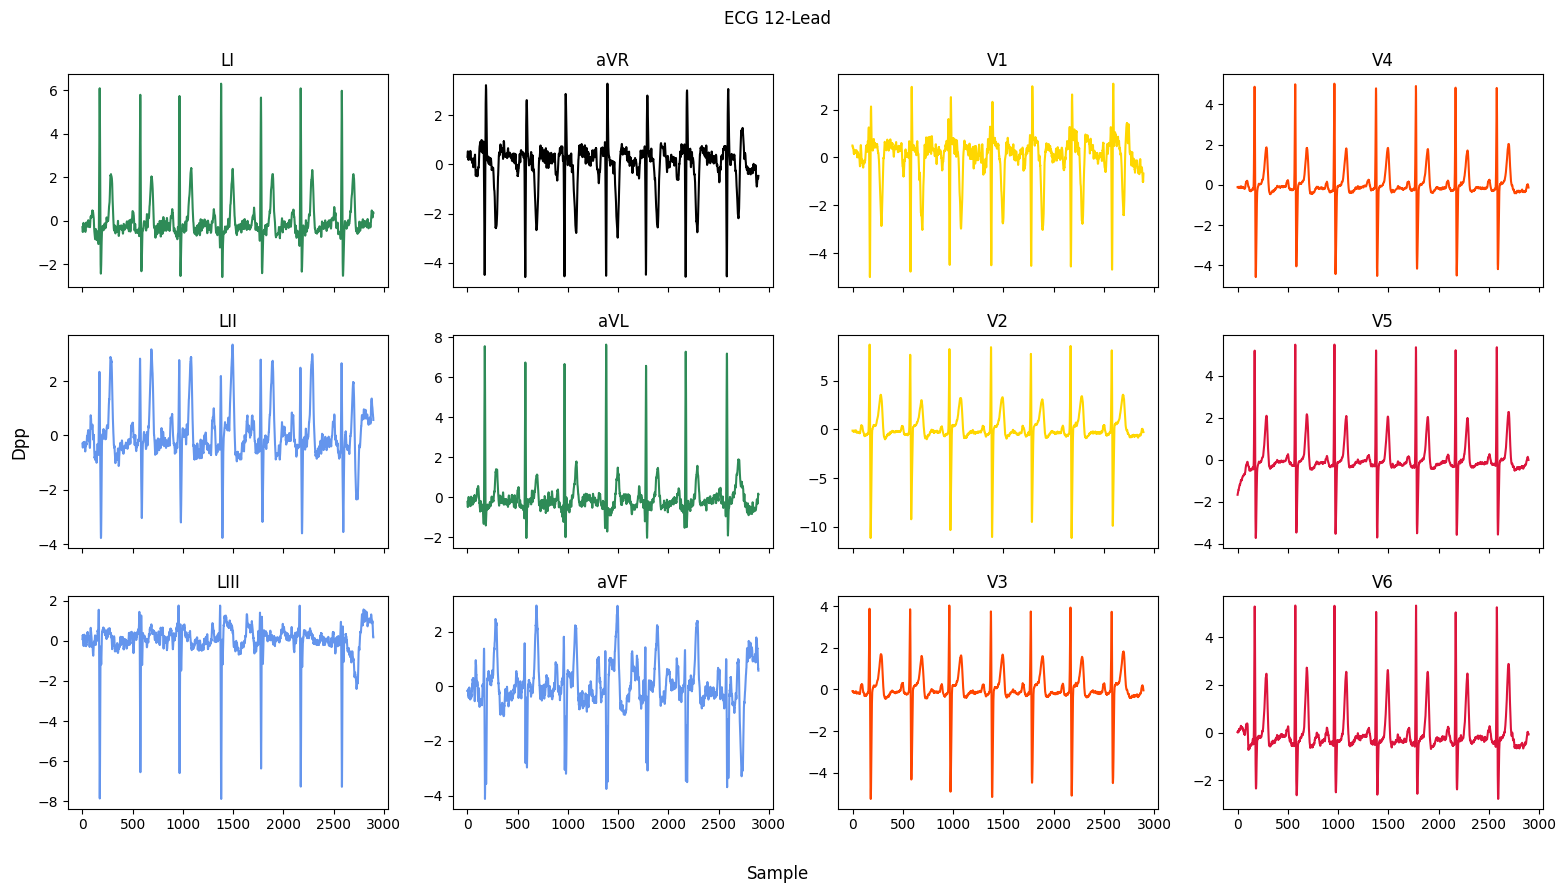

In [27]:
plotECG(
    ecg     = sampleECG,
    headers = ecgPlotHeaders,
    colors  = ecgPlotColors
)

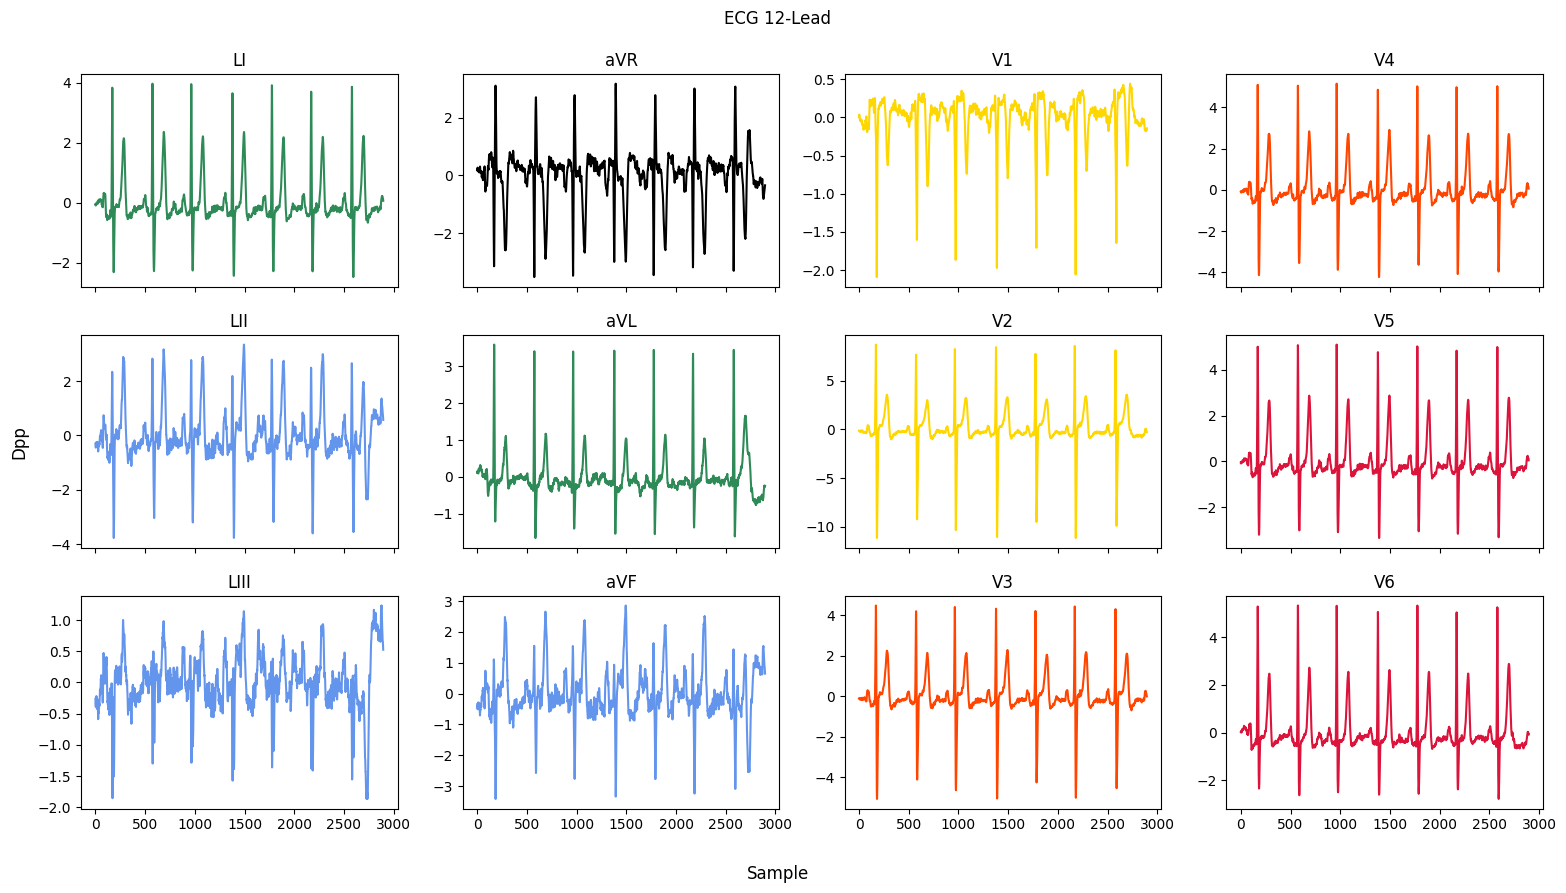

In [28]:
plotECG(
    ecg     = sampleECGReconstructed,
    headers = ecgPlotHeaders,
    colors  = ecgPlotColors
)

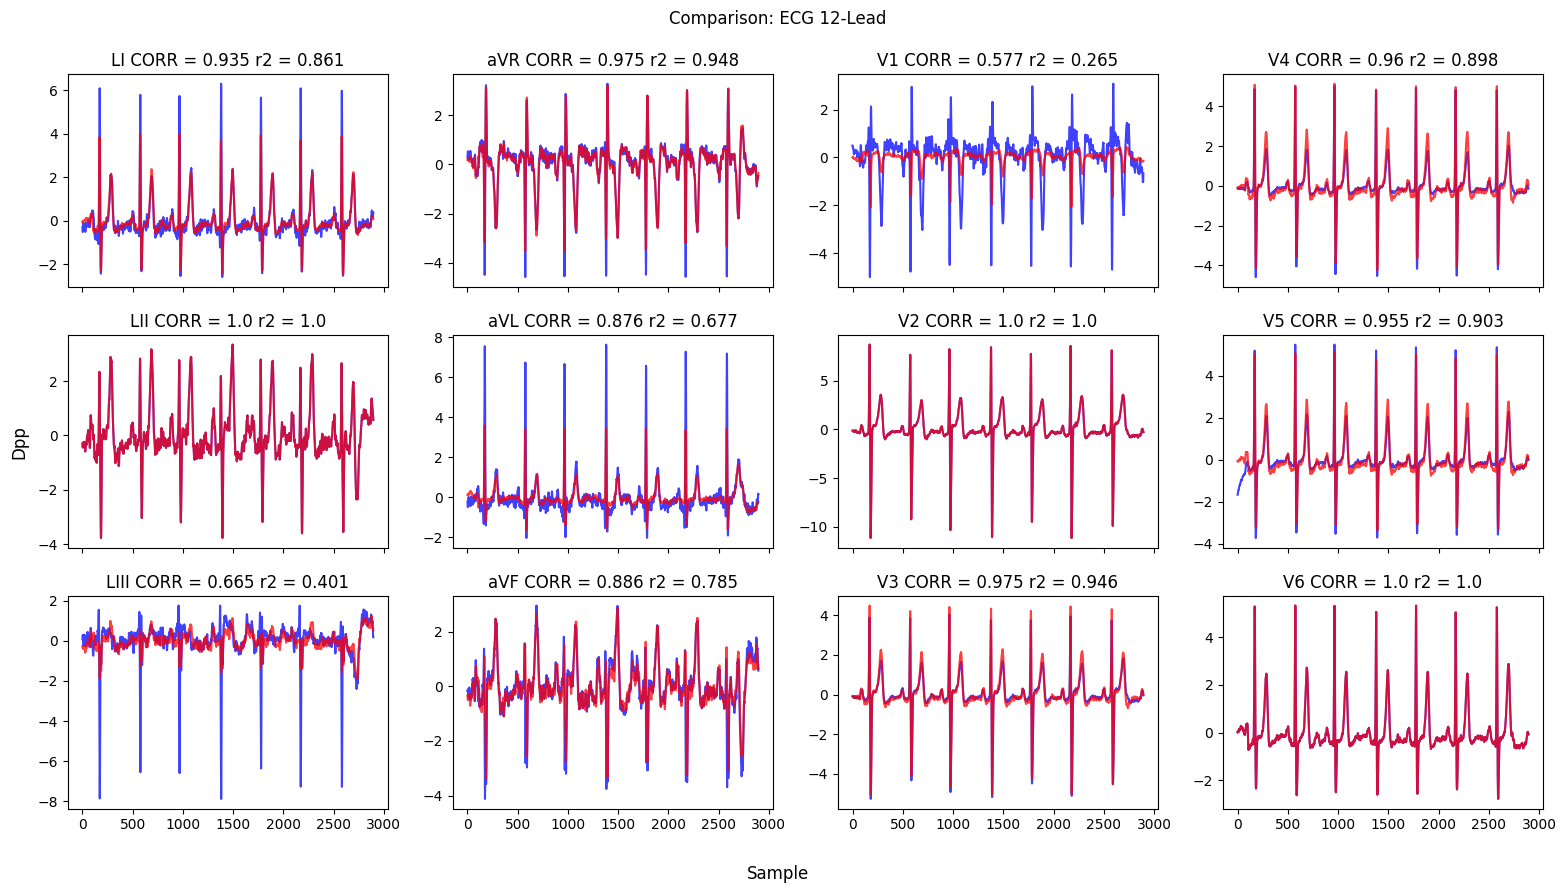

In [29]:
comparativeFullEcgPlot(
	ecgOring = sampleECG,
	ecgRec   = sampleECGReconstructed,
	headers  = ecgPlotHeaders
)

In [30]:
viewWindow = slice(1000, 2000)

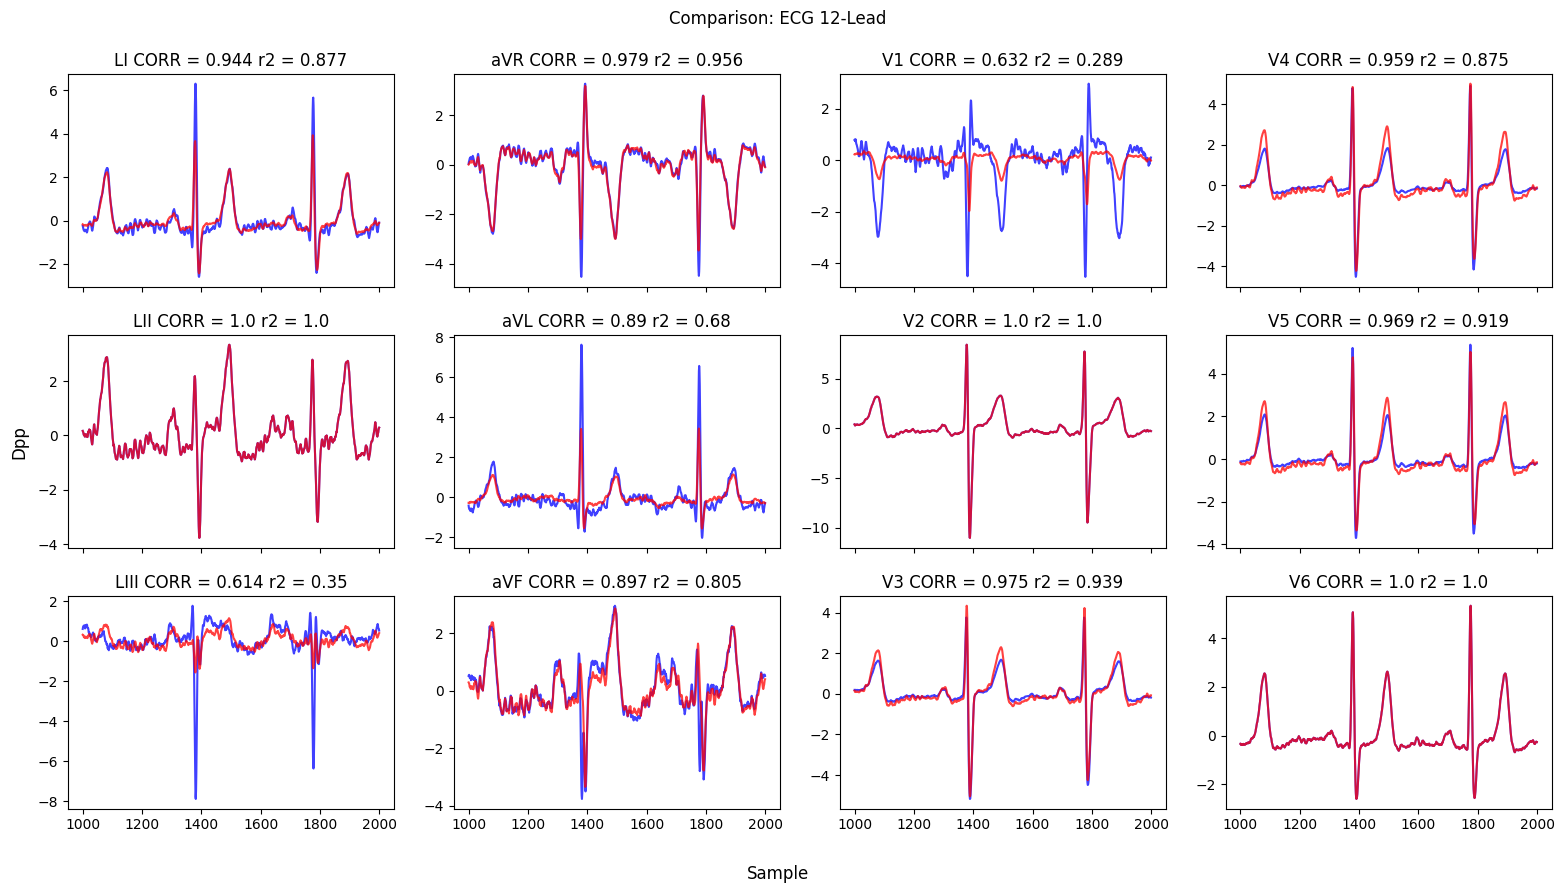

In [31]:
comparativeFullEcgPlot(
	ecgOring = sampleECG[viewWindow],
	ecgRec   = sampleECGReconstructed[viewWindow],
	headers  = ecgPlotHeaders
)

# Save model

In [32]:
torch.save(model.state_dict(), "../../../models/t1/reglin-t1-v1.pth")